In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 3)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.formula.api as smf


In [3]:
df_mindset = pd.read_csv('learning_mindset.csv')
print(df_mindset.info())
df_mindset.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schoolid                10391 non-null  int64  
 1   intervention            10391 non-null  int64  
 2   achievement_score       10391 non-null  float64
 3   success_expect          10391 non-null  int64  
 4   ethnicity               10391 non-null  int64  
 5   gender                  10391 non-null  int64  
 6   frst_in_family          10391 non-null  int64  
 7   school_urbanicity       10391 non-null  int64  
 8   school_mindset          10391 non-null  float64
 9   school_achievement      10391 non-null  float64
 10  school_ethnic_minority  10391 non-null  float64
 11  school_poverty          10391 non-null  float64
 12  school_size             10391 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 1.0 MB
None


,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277,6,4,2,1,4,0.335,0.649,-1.311,0.224,-0.427
1,76,1,-0.450,4,12,2,1,4,0.335,0.649,-1.311,0.224,-0.427
2,76,1,0.770,6,4,2,0,4,0.335,0.649,-1.311,0.224,-0.427
3,76,1,-0.122,6,4,2,0,4,0.335,0.649,-1.311,0.224,-0.427
4,76,1,1.526,6,4,1,0,4,0.335,0.649,-1.311,0.224,-0.427


In [13]:
# Convert categorical values to binary indicators (one-hot)
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

df_categ = pd.concat([
    df_mindset.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(df_mindset[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

df_categ.head()

,schoolid,intervention,achievement_score,success_expect,frst_in_family,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,...,ethnicity_13,ethnicity_14,ethnicity_15,gender_1,gender_2,school_urbanicity_0,school_urbanicity_1,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,76,1,0.277,6,1,0.335,0.649,-1.311,0.224,-0.427,...,0,0,0,0,1,0,0,0,0,1
1,76,1,-0.450,4,1,0.335,0.649,-1.311,0.224,-0.427,...,0,0,0,0,1,0,0,0,0,1
2,76,1,0.770,6,0,0.335,0.649,-1.311,0.224,-0.427,...,0,0,0,0,1,0,0,0,0,1
3,76,1,-0.122,6,0,0.335,0.649,-1.311,0.224,-0.427,...,0,0,0,0,1,0,0,0,0,1
4,76,1,1.526,6,0,0.335,0.649,-1.311,0.224,-0.427,...,0,0,0,1,0,0,0,0,0,1


In [14]:
T = 'intervention'
Y = 'achievement_score'
X = df_categ.columns.drop([T, Y])

/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


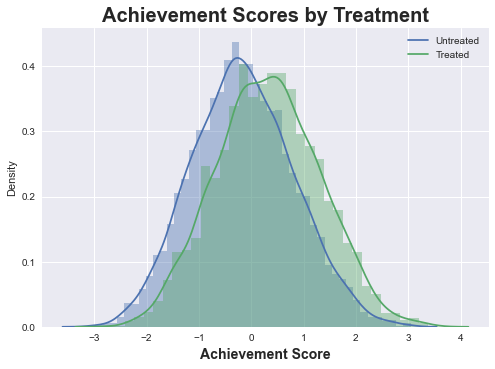

In [6]:
sns.distplot(df_mindset['achievement_score'][df_categ['intervention'] == 0], kde=True)
sns.distplot(df_mindset['achievement_score'][df_categ['intervention'] == 1], kde=True)
plt.title("Achievement Scores by Treatment", fontsize=20, fontweight = 'bold')
plt.xlabel('Achievement Score', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['Untreated', 'Treated'])
plt.savefig('Naive.png')

In [7]:
# Define Estimation methods

# Linear Regression T on Y
def naive_ATE(df, T, Y):
    return df[Y][df_categ[T] == 1].mean() - df_categ[Y][df_categ[T] == 0].mean()

# IPW
def IPW(df, X, T, Y,true_ps = True):

    if true_ps:
        p_scores = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    else:
        p_scores = np.random.uniform(0.1, 0.9, df.shape[0])

    df_ps = df.assign(propensity_score=p_scores)

    weight = ((df_ps["intervention"]-df_ps["propensity_score"]) / (df_ps["propensity_score"]*(1-df_ps["propensity_score"])))

    weight_t = 1/df_ps.query("intervention==1")["propensity_score"]
    weight_nt = 1/(1-df_ps.query("intervention==0")["propensity_score"])

    y1 = sum(df_ps.query("intervention==1")["achievement_score"]*weight) / len(df_ps)
    y0 = sum(df_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(df_ps)

    return np.mean(weight * df_ps["achievement_score"]), p_scores, df_ps




# AIPW
def AIPW(df, X, T, Y,true_ps = True,true_mus = True):
    if true_ps:
        p_scores = LogisticRegression(C=1e6,max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    else:
        p_scores = np.random.uniform(0.1, 0.9, df.shape[0])

    if true_mus:
        mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
        mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    else:
        mu0 = np.random.uniform(0, 1, df.shape[0])
        mu1 = np.random.uniform(0, 1, df.shape[0])

    return (
        np.mean(df[T]*(df[Y] - mu1)/p_scores + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-p_scores) + mu0)
    ), p_scores, mu0, mu1

# OG Github
def doubly_robust_bad(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [8]:
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in tqdm(range(bootstrap_sample)):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.distplot(AIPW_ates, kde=True)
sns.distplot(IPW_ates, kde=True)
sns.distplot(naives_ates, kde=True)
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])
plt.savefig('Bootstrap-Compare.png')

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T


  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'T' is not defined

/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


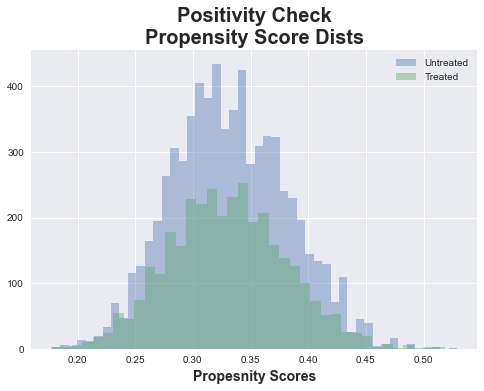

In [21]:
sns.distplot(ps[df_categ['intervention']==0], kde=False)
sns.distplot(ps[df_categ['intervention']==1], kde=False)
plt.title("Positivity Check\nPropensity Score Dists", fontsize=20, fontweight = 'bold')
plt.xlabel('Propesnity Scores', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['Untreated', 'Treated'])
plt.savefig('Positivity Check.png')

100%|██████████| 100/100 [00:06<00:00, 14.32it/s]
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future versi

,Mean ATE,Std Dev,[.025,.975]
AIPW,0.383,0.022,0.338,0.418
IPW,0.568,0.033,0.482,0.622
Naive,0.469,0.017,0.433,0.498


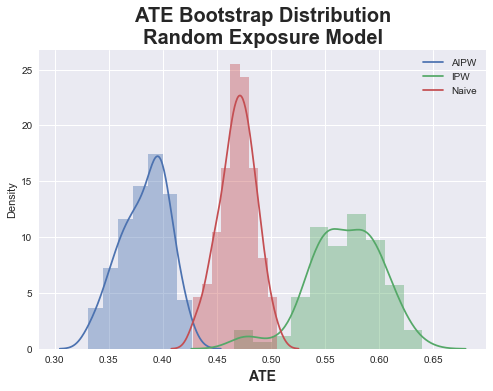

In [11]:
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in tqdm(range(bootstrap_sample)):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y,true_ps=False)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y,true_ps=False)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.distplot(AIPW_ates, kde=True)
sns.distplot(IPW_ates, kde=True)
sns.distplot(naives_ates, kde=True)
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution\nRandom Exposure Model", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])
plt.savefig('Bootstrap-Compare_badPS.png')

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future versi

,Mean ATE,Std Dev,[.025,.975]
AIPW,0.385,0.017,0.352,0.413
IPW,0.385,0.016,0.354,0.412
Naive,0.471,0.016,0.440,0.500


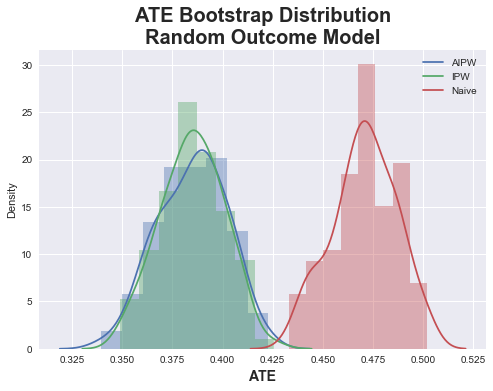

In [12]:
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in tqdm(range(bootstrap_sample)):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y,true_mus=False)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.distplot(AIPW_ates, kde=True)
sns.distplot(IPW_ates, kde=True)
sns.distplot(naives_ates, kde=True)
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution\nRandom Outcome Model", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])
plt.savefig('Bootstrap-Compare_badmu.png')

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T

In [ ]:
ate, ps,df_ps = IPW(df_categ, X, T, Y)
smf.ols("achievement_score ~ intervention + propensity_score", data=df_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0917,0.065,-47.605,0.000,-3.219,-2.964
intervention,0.3922,0.019,20.971,0.000,0.356,0.429
propensity_score,9.1034,0.199,45.855,0.000,8.714,9.493


100%|██████████| 100/100 [00:03<00:00, 31.83it/s]
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future versi

,Mean ATE,Std Dev,[.025,.975]
AIPW,1.053,0.037,0.988,1.117
IPW,0.571,0.027,0.523,0.627
Naive,0.471,0.017,0.441,0.504


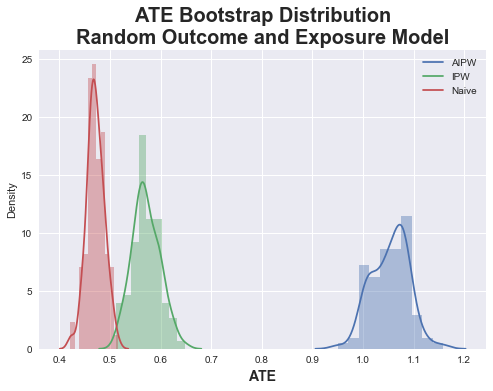

In [14]:
bootstrap_sample = 100
AIPW_ates = []
IPW_ates = []
naives_ates = []
for iSample in tqdm(range(bootstrap_sample)):
    df_bootstrap = df_categ.sample(frac=1,replace=True)
    ate, ps, mu0, mu1 = AIPW(df_bootstrap, X, T, Y,true_mus=False,true_ps=False)
    AIPW_ates.append(ate)
    ate, ps,_ = IPW(df_bootstrap, X, T, Y,true_ps=False)
    IPW_ates.append(ate)
    naives_ates.append(naive_ATE(df_bootstrap, T, Y))

sns.distplot(AIPW_ates, kde=True)
sns.distplot(IPW_ates, kde=True)
sns.distplot(naives_ates, kde=True)
# plt.vlines(np.percentile(AIPW_ates, 2.5), 0, 20, linestyles="dotted")
# plt.vlines(np.percentile(AIPW_ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution\nRandom Outcome and Exposure Model", fontsize=20, fontweight = 'bold')
plt.xlabel('ATE', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['AIPW', 'IPW', 'Naive'])
plt.savefig('Bootstrap-Compare_badBoth.png')

Results = {"AIPW":{"Mean ATE":np.mean(AIPW_ates), "Std Dev":np.std(AIPW_ates), "[.025":np.percentile(AIPW_ates, 2.5), ".975]":np.percentile(AIPW_ates, 97.5)},
"IPW":{"Mean ATE":np.mean(IPW_ates), "Std Dev":np.std(IPW_ates), "[.025":np.percentile(IPW_ates, 2.5), ".975]":np.percentile(IPW_ates, 97.5)},
"Naive":{"Mean ATE":np.mean(naives_ates), "Std Dev":np.std(naives_ates), "[.025":np.percentile(naives_ates, 2.5), ".975]":np.percentile(naives_ates, 97.5)}}

df_results = pd.DataFrame(Results)
df_results.T